# Preprocessing
This processes all c. 18M COSMO-RS datapoints

In [3]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from chemprop.data import scaffold_to_smiles, generate_scaffold
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from pathlib import Path
import pkg_resources
from rdkit import Chem
from typing import List
from IPython.display import clear_output

In [4]:
import psutil
from psutil._common import bytes2human

def get_mem():
    mem_usage = psutil.virtual_memory()
    return f"Availble memory: {bytes2human(mem_usage[1])}"
get_mem()

'Availble memory: 7.4G'

## Parameters

In [5]:

# Get parameters
installed = {pkg.key for pkg in pkg_resources.working_set}
if "orchest" in installed:
    import orchest
    # Get params
    step_params, pipeline_params = orchest.parameters.get_params()
    inputs = orchest.get_inputs()
    molecule_df = inputs["molecule_df"]
else:
    step_params = {}
    pipeline_params = {}
    inputs = {}
    molecule_df = pd.read_csv("../data/cosmo/solvent_descriptors.csv")

# Number of batches produced by ../data/cosmo/post_process_gammas.py
n_batches = step_params.get("n_batches", 191)

# Path to CSV files produced by ../data/cosmo/post_process_gammas.py
data_path  = pipeline_params.get("data_path", "../data/cosmo/cosmo_batches/")
data_path = Path(data_path)

# Prefix of columns in CSV files that need to be resolved. Defaults to cas_number
input_column_prefix =  step_params.get("input_column_prefix","cas_number")

# Test size
test_size = step_params.get("test_size", 0.1)

# Get the name of the input column from the df outputed by the resolution step
molecule_df_input_column = inputs.get("molecule_df_input_column", "cas_number")

## Resolve names to SMILES

In [6]:
# Resolve to SMILES by merging
def resolve_smiles(df, molecule_df):
    df = df.drop("Unnamed: 0", axis=1)
    new_df = df.copy()
    drop_columns = molecule_df.columns.tolist()
    drop_columns.remove("smiles")
    for i in [1,2]:
        new_df = pd.merge(
            new_df,
            molecule_df,
            left_on=f"{input_column_prefix}_{i}",
            right_on=molecule_df_input_column, 
            how="left"
        )
        new_df = new_df.rename(columns={"smiles": f"smiles_{i}"}).drop(drop_columns, axis=1)

        # Deal with the molecule_df that don't have a CAS number
        # The cosmo name was used instead
        names = (df
                 .mask(df[f"cas_number_{i}"]
                 .str.contains(r"\b[1-9]{1}[0-9]{1,5}-\d{2}-\d\b", regex=True))
                 .reset_index()
                 .dropna()
                 .drop("index", axis=1)
                 .reset_index()
        )
        smiles_names = pd.merge(names, molecule_df, left_on=f"cas_number_{i}", right_on="cosmo_name").set_index("index")
        smiles_names = smiles_names[["smiles"]].rename(columns={"smiles": f"smiles_{i}"})
        new_df.update(smiles_names)
        new_df =  new_df.dropna()
    return new_df

In [7]:
dfs = []
for i in range(n_batches):
    print(get_mem())
    print(f"Reading in COMSO Data: batch {i+1} of {n_batches}")
    df = pd.read_csv(data_path / f"batch_{i}.csv")
    print(f"Resolving batch {i+1} of {n_batches}")
    new_df = resolve_smiles(df, molecule_df)
    dfs.append(new_df)
    clear_output(wait=True)
df = pd.concat(dfs)
print(f"Total Rows: {df.shape[0]}")

Total Rows: 18865088


In [8]:
print(f"Total Rows: ~{df.shape[0]/1e6:.0f}M")

Total Rows: ~19M


In [9]:
# Save intermediate data in case a failure occurs
df.to_csv("../data/cosmo/cosmo_data.csv")

## Train-test split

I will do a scaffold split to test how well the model does on unseen scaffolds.

In [37]:
def scaffold_groups(mols: List[str]):
    """ Find all the scaffolds and reference each one by index
    
    Parameters
    ---------
    mols: list of str
        The list of smiles strings
    
    Returns
    -------
    scaffolds, scaffold_indices
        scaffolds is a dictionary mapping scaffold to index.
        scaffold_indices gives the index of the scaffold for each molecule
    """
    scaffolds = dict()
    scaffold_num = 0
    scaffold_list = [""]*len(mols)
    n_mols = len(mols)
    for i, mol in enumerate(mols):
        print(f"{(i+1)/n_mols*100:.0f}% ({i+1} of {n_mols})")
        scaffold = generate_scaffold(mol)
        if scaffold not in scaffolds:
            scaffolds[scaffold] = scaffold_num
            scaffold_num +=1
        scaffold_list[i] = scaffold
        clear_output(wait=True)
    scaffold_indices = [scaffolds[s] for s in scaffold_list]
    return scaffolds, scaffold_indices

In [58]:
# Get scaffolds
unique_mols = pd.unique(df["smiles_1"])
scaffolds, scaffold_indices = scaffold_groups(unique_mols) 
print(f"Number of scaffolds: {len(scaffolds)}")

Number of scaffolds: 47


In [52]:
# Merge scaffolds into big dataframe
scaffold_df = pd.DataFrame({"smiles": unique_mols, "scaffold_index": scaffold_indices})
df = df.merge(scaffold_df, left_on="smiles_1", right_on="smiles", how="left")

There are 47 scaffolds, so a 90/10 split will put ~42 scaffolds in train and 5 in test.

In [97]:
# Big train-test split
splitter = GroupShuffleSplit(n_splits=2, train_size=0.9, random_state=1995)
train_indices, test_indices = next(splitter.split(X=df, groups=df["scaffold_index"]))
train_df = df.iloc[train_indices]
test_df = df.iloc[test_indices]
print(f"Training set size: ~{train_df.shape[0]/1e6:.0f}M")
print(f"Test set size: ~{test_df.shape[0]/1e3:.0f}k")

Training set size: ~19M
Test set size: ~212k


One caveat is that the Bemis-Murcko scaffold algorithm is used, which relies on ring structure. Since a lot the solvents don't have ring structure, many end up in the "null" scaffold.

In [126]:
null_scaffold = scaffolds[""]
scaffold_counts = df["scaffold_index"].value_counts()
print(f"Number of records that match the null scaffold: ~{scaffold_counts.loc[null_scaffold]/1e6:.0f}M")

Number of records that match the null scaffold: ~12M


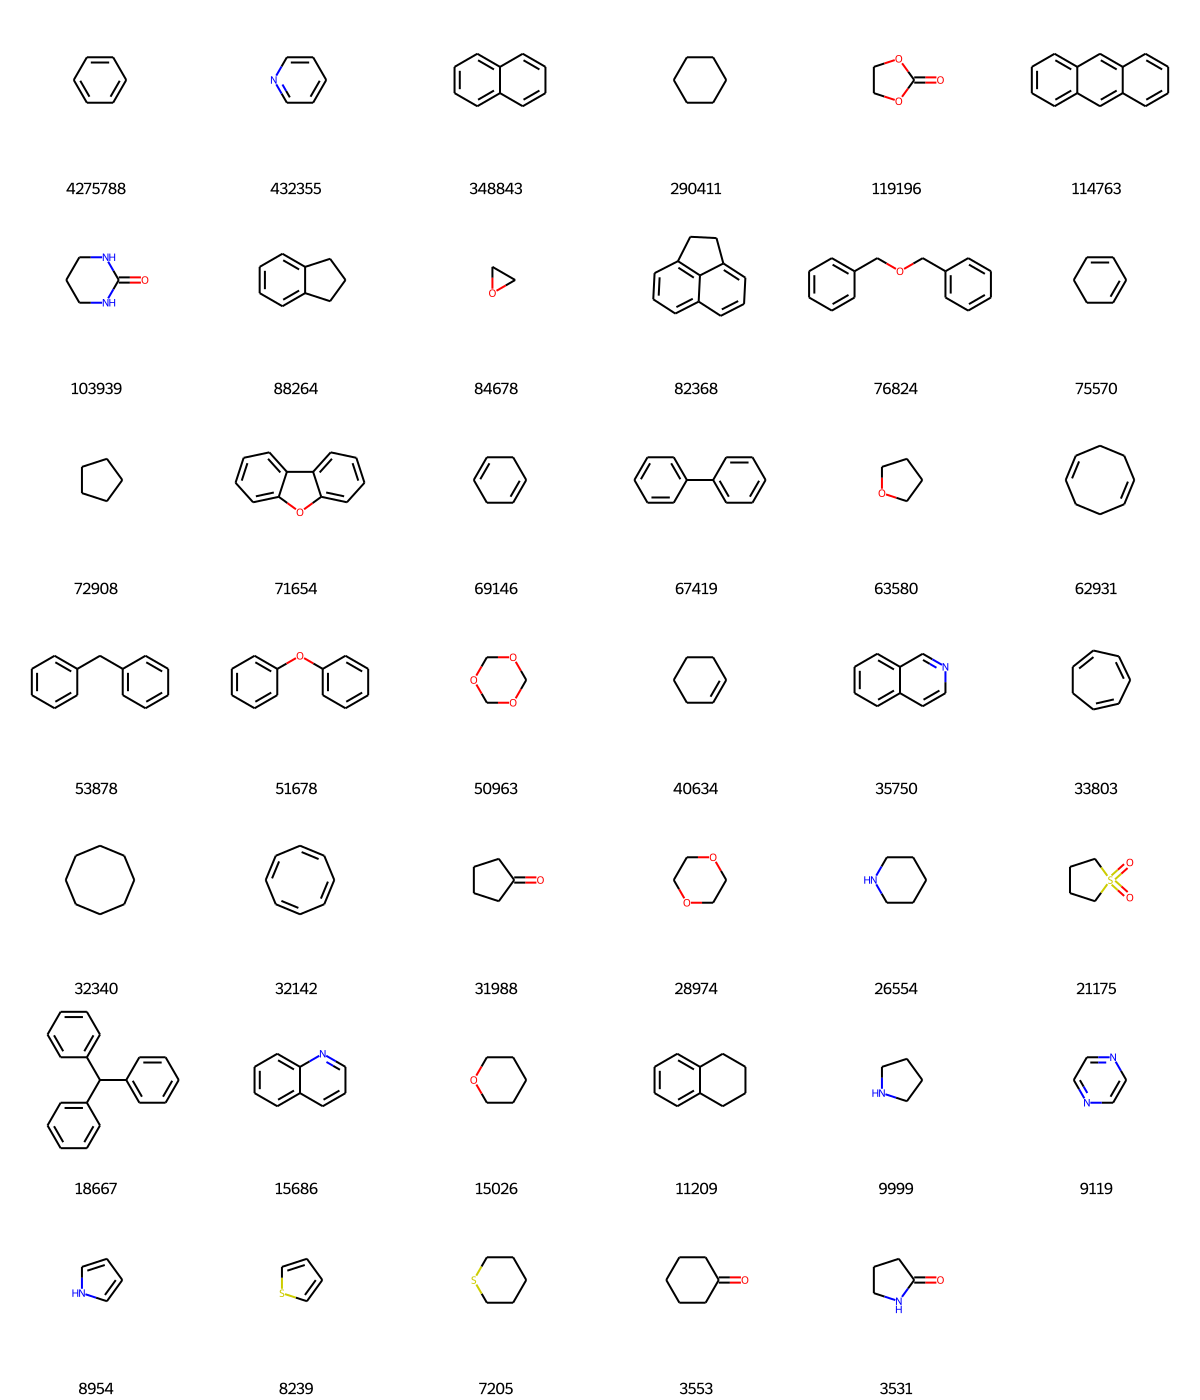

In [122]:
# Visualize scaffolds with counts of scaffolds below each molecule
train_scaffold_counts = train_df["scaffold_index"].value_counts()
null_scaffold = scaffolds[""]
scaffold_idx_to_smiles = {idx: scaffold for scaffold, idx in scaffolds.items()}
img = Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(scaffold_idx_to_smiles[idx]) 
     for idx in train_scaffold_counts.index if idx!=null_scaffold
    ],
    molsPerRow=6,subImgSize=(200,200),
    legends= [
       str(train_scaffold_counts.iloc[i]) 
       for i in range(len(train_scaffold_counts)) if train_scaffold_counts.index[i]!=null_scaffold
    ],
    returnPNG=False
)
img.save("../figures/train_cosmo_scaffolds.png")
img

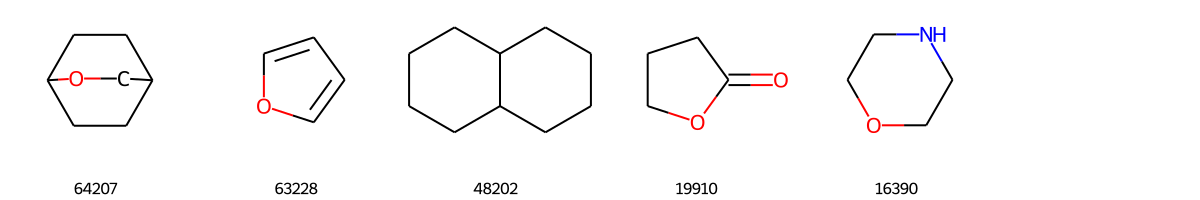

In [121]:
# Visualize test scaffolds with number of repeats below each molecule
test_scaffold_counts = test_df["scaffold_index"].value_counts()
null_scaffold = scaffolds[""]
scaffold_idx_to_smiles = {idx: scaffold for scaffold, idx in scaffolds.items()}
img = Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(scaffold_idx_to_smiles[idx]) 
     for idx in test_scaffold_counts.index if idx!=null_scaffold
    ],
    molsPerRow=6,subImgSize=(200,200),
    legends= [
       str(test_scaffold_counts.iloc[i]) 
       for i in range(len(test_scaffold_counts)) if test_scaffold_counts.index[i]!=null_scaffold
    ],
    returnPNG=False
)
img.save("../figures/test_cosmo_scaffolds.png")
img

## Output data

In [127]:
# Create a separate files for smiles and features
print("Saving data out for next step")
train_columns = ["smiles_1", "smiles_2", "ln_gamma_1", "ln_gamma_2"]
features_columns = ["temperature (K)", "x(1)", "x(2)"]
train_df[train_columns].to_csv(data_path / "train_cosmo_data.csv", index=False)
train_df[features_columns].to_csv(data_path / "train_cosmo_features.csv", index=False)
test_df[train_columns].to_csv(data_path / "test_cosmo_data.csv", index=False)
test_df[features_columns].to_csv(data_path / "test_cosmo_features.csv", index=False)
print("Success!")

Saving data out for next step
Success!


## Random Subsampling

The data + related MolGraphs are way too large to fit into the memory of the P4000 GPU, so I am going to [subsample](https://www2.eecs.berkeley.edu/Pubs/TechRpts/2013/EECS-2013-94.pdf). I did some basic tests, and it looks like 3M samples with a batch size of 400 works pretty well.

In [ ]:
train_df = pd.read_csv(data_path / "train_cosmo_data.csv")
train_df_features = pd.read_csv(data_path / "train_cosmo_features.csv")

In [19]:
n_samples = int(3e6)
n_train = train_df.shape[0]
n_subsample_runs = n_train // n_samples
n_subsample_runs += 1 if n_train % n_samples > 0 else 0
mask = np.ones(n_train, dtype=bool)
for i in range(n_subsample_runs-1):
    print(f"Subsample {i+1} of {n_subsample_runs}")
    samples = train_df.loc[mask].sample(n_samples)
    samples.to_csv(f"../data/cosmo/random_subsampling/train_subsamples_{i}.csv", index=False)
    samples_features = train_df_features.loc[samples.index]
    samples_features.to_csv(f"../data/cosmo/random_subsampling/train_subsamples_features_{i}.csv", index=False)
    mask[samples.index] = 0
    clear_output(wait=True)
print(f"Subsample {i+1} of {n_subsample_runs}")
train_df.loc[mask].to_csv(f"../data/cosmo/random_subsampling/train_subsamples_{i+1}.csv", index=False)
train_df_features.loc[mask].to_csv(
    f"../data/cosmo/random_subsampling/train_subsamples_features_{i+1}.csv", index=False)

Subsample 6 of 7
